<a href="https://colab.research.google.com/github/tombackert/brain-tumor/blob/main/brain-tumor-mri-classification-xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook objectives
- Use Xception to classify brain tumors

In [1]:
### This section is for Kaggle use only and can be ignored

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
### Imports

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#---------------------------------------


import warnings
warnings.filterwarnings("ignore")


# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

# Explanatory Data Analysis

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not founde')
print('Found GPU at: {}'.format(device_name))

In [6]:
### For colab use only

if not os.path.exists('brain-tumor-mri-dataset'):
    !git clone https://github.com/tombackert/brain-tumor.git

def load_df(path):
    classes, class_paths = zip(*[(label, os.path.join(path, label, image))
                                 for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                 for image in os.listdir(os.path.join(path, label)) if image.endswith('.jpg')])

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

df = load_df('./brain-tumor/brain-tumor-mri-dataset')

Cloning into 'brain-tumor'...
remote: Enumerating objects: 6743, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6743 (delta 0), reused 4 (delta 0), pack-reused 6733 (from 1)
Receiving objects: 100% (6743/6743), 142.29 MiB | 23.07 MiB/s, done.
Updating files: 100% (7155/7155), done.


In [4]:
### For kaggle use only

def load_df(path):
    classes, class_paths = zip(*[(label, os.path.join(path, label, image))
                                 for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                 for image in os.listdir(os.path.join(path, label))])

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df


df = load_df('/kaggle/input/brain-tumor-mri-data/brain-tumor-mri-dataset')

In [7]:
df

,Class Path,Class
0,./brain-tumor/brain-tumor-mri-dataset/notumor/...,notumor
1,./brain-tumor/brain-tumor-mri-dataset/notumor/...,notumor
2,./brain-tumor/brain-tumor-mri-dataset/notumor/...,notumor
3,./brain-tumor/brain-tumor-mri-dataset/notumor/...,notumor
4,./brain-tumor/brain-tumor-mri-dataset/notumor/...,notumor
...,...,...
7148,./brain-tumor/brain-tumor-mri-dataset/pituitar...,pituitary
7149,./brain-tumor/brain-tumor-mri-dataset/pituitar...,pituitary
7150,./brain-tumor/brain-tumor-mri-dataset/pituitar...,pituitary
7151,./brain-tumor/brain-tumor-mri-dataset/pituitar...,pituitary


In [ ]:
### Function for counting images in each class
def count_images(df):
  plt.figure(figsize=(15,7))
  ax = sns.countplot(data=df, y=df['Class'], palette='rocket')

  plt.xlabel('')
  plt.ylabel('')
  plt.title('Count of images in each class')
  ax.bar_label(ax.containers[0])
  plt.show()

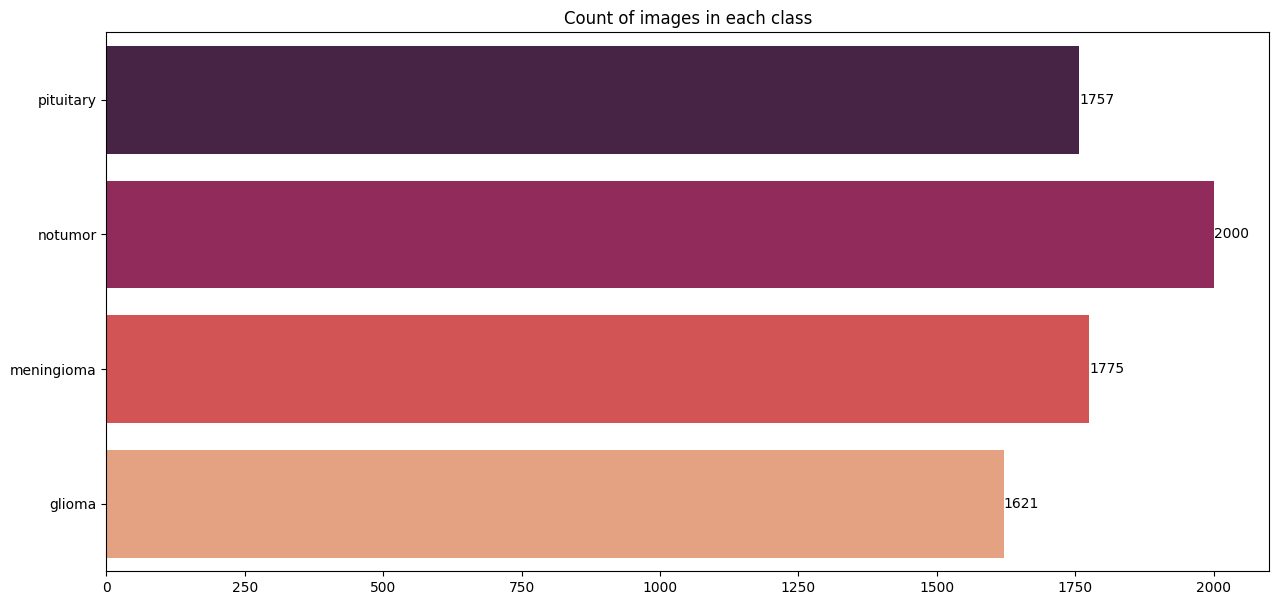

In [ ]:
count_images(df)

In [ ]:
# Train: 81.7%, Validation: 9.1%, Test: 9.2%

train_df, test_val_df = train_test_split(df, train_size=5842 / 7153, random_state=42, stratify=df['Class'])

valid_df, test_df = train_test_split(test_val_df, train_size=655 / len(test_val_df), random_state=20, stratify=test_val_df['Class'])

print(f"Train size: {len(train_df)} rows")
print(f"Validation size: {len(valid_df)} rows")
print(f"Test size: {len(test_df)} rows")

Train size: 5842 rows
Validation size: 655 rows
Test size: 656 rows


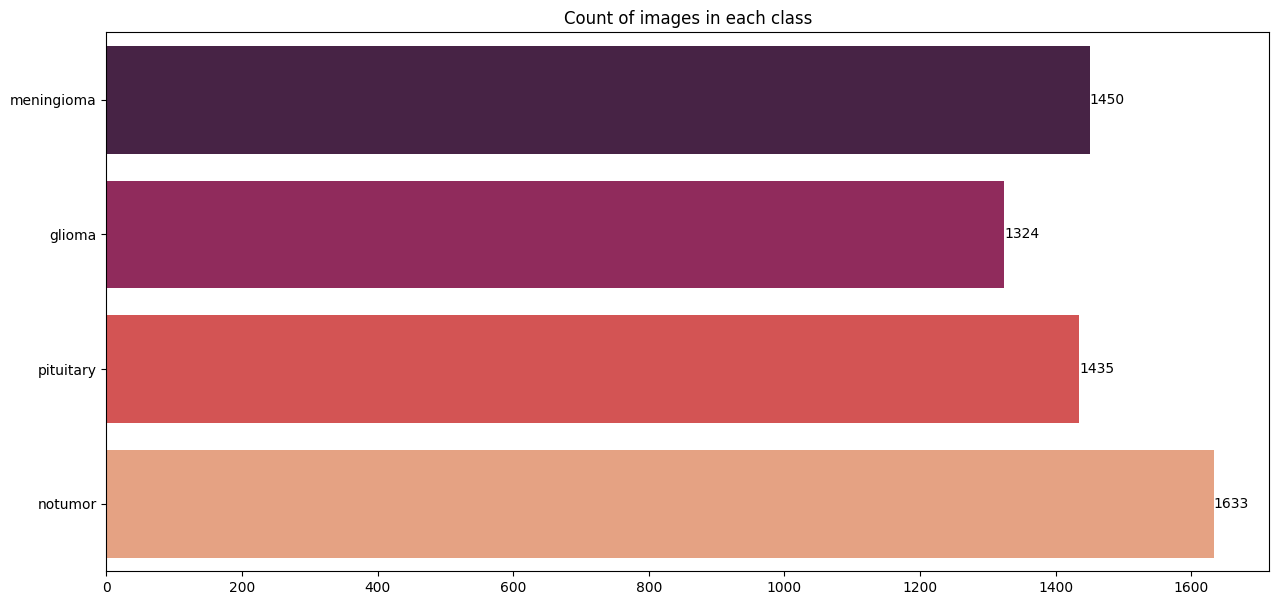

In [ ]:
count_images(train_df)

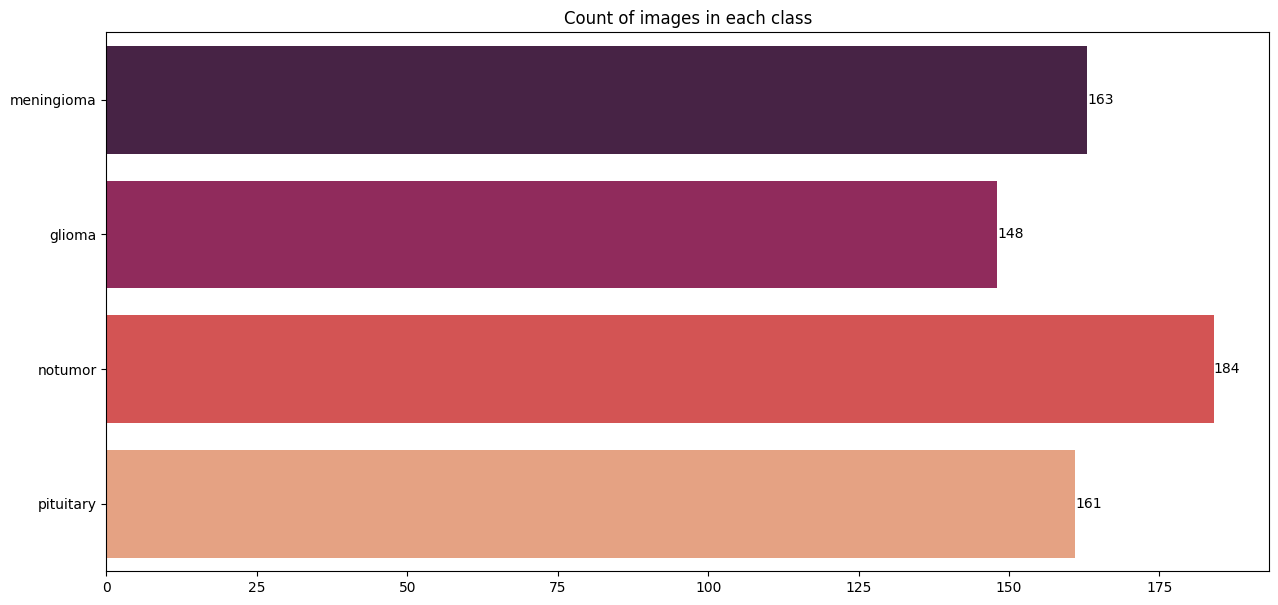

In [ ]:
count_images(test_df)

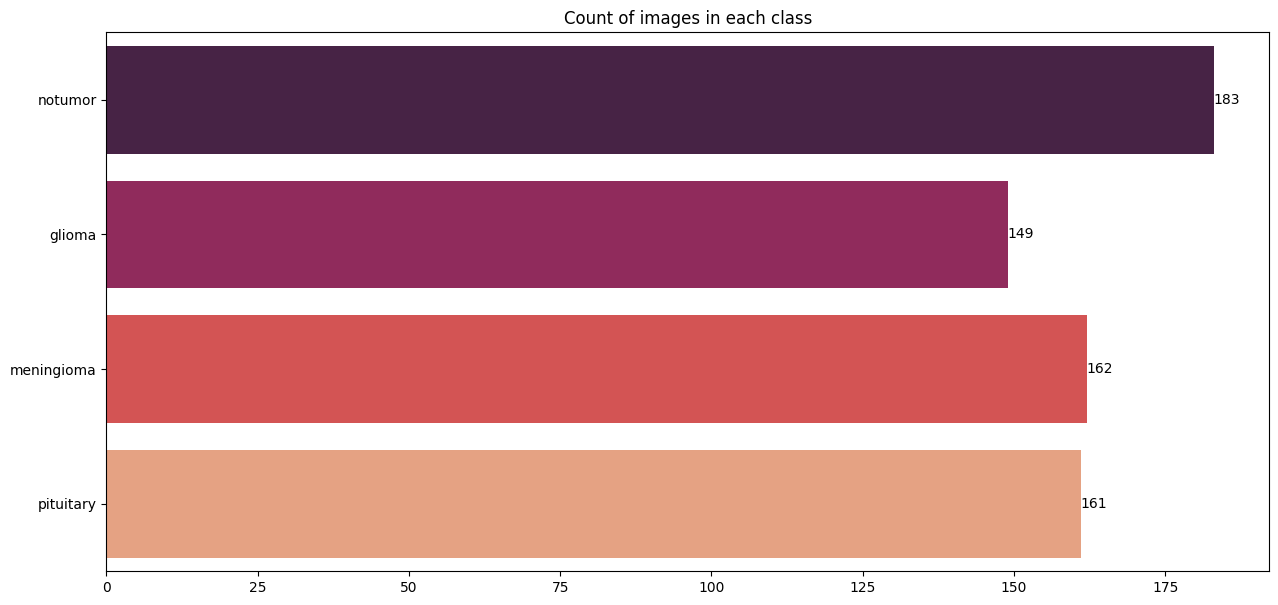

In [ ]:
count_images(valid_df)

# Data Preprocessing

In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5842 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


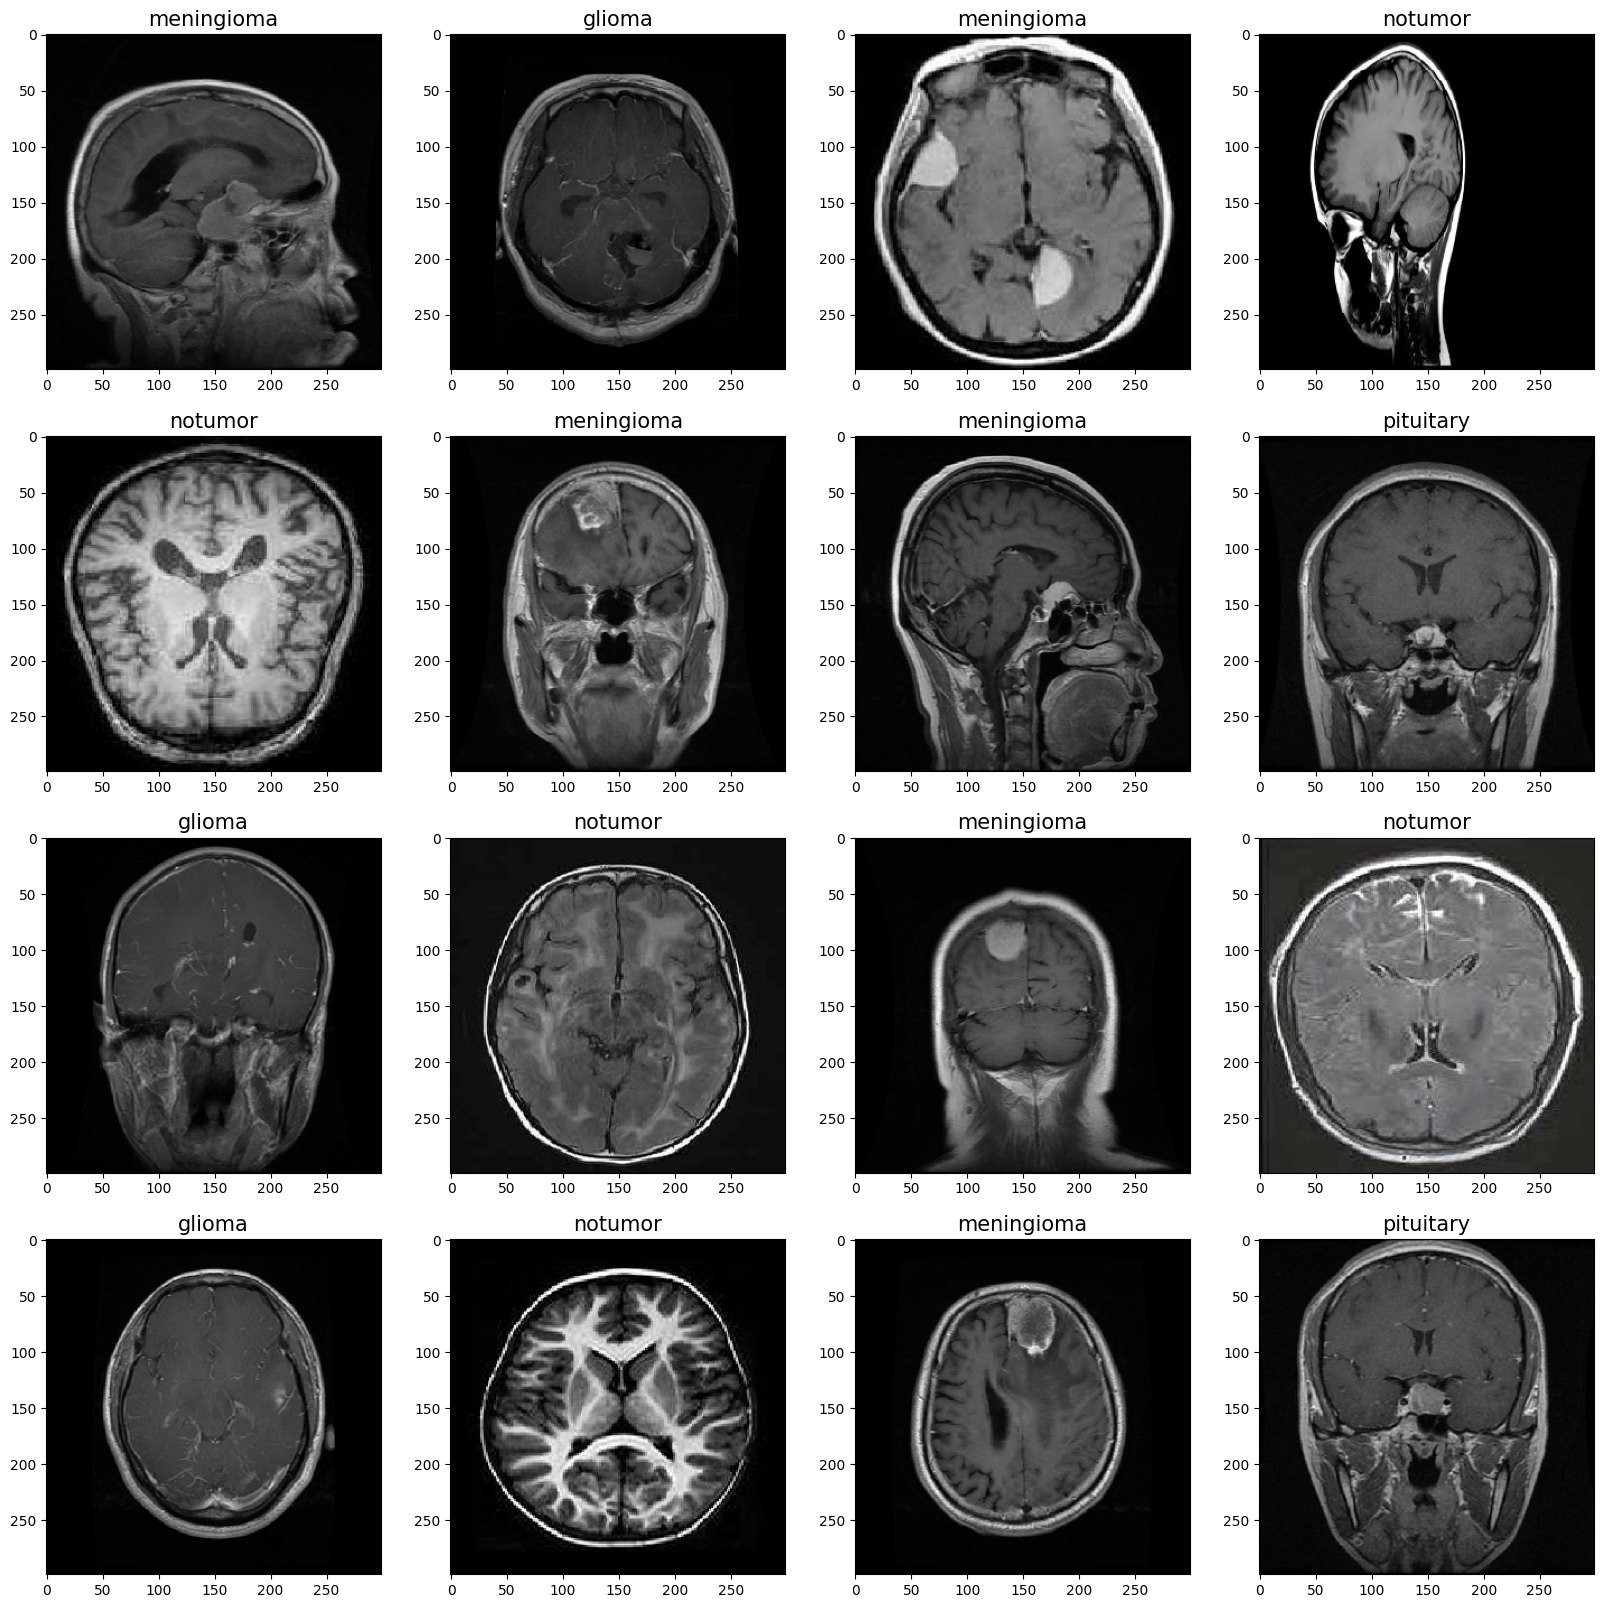

In [ ]:
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# Model Building

In [ ]:
### Model Building

img_shape = (299,299,3)
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape,
                                            pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
#base_model.summary()

# Model Training

In [ ]:
### Training Loop on GPU

with tf.device(device_name):
  hist = model.fit(train_gen,
                   epochs=10,
                   validation_data=valid_gen,
                   shuffle=False)

Epoch 1/10


I0000 00:00:1732315832.335386      71 service.cc:145] XLA service 0x7a26e0001df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732315832.335445      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732315832.335451      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-22 22:50:43.793244: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-22 22:50:43.79387

183/183 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.4197 - loss: 1.3434 - precision: 0.6223 - recall: 0.1128 - val_accuracy: 0.5405 - val_loss: 1.1327 - val_precision: 0.6296 - val_recall: 0.2595
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 176s 961ms/step - accuracy: 0.6425 - loss: 0.8850 - precision: 0.8950 - recall: 0.3586 - val_accuracy: 0.9008 - val_loss: 0.5036 - val_precision: 0.9142 - val_recall: 0.6672
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 175s 956ms/step - accuracy: 0.9405 - loss: 0.4022 - precision: 0.9647 - recall: 0.6887 - val_accuracy: 0.9588 - val_loss: 0.2731 - val_precision: 0.9559 - val_recall: 0.7282
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 175s 956ms/step - accuracy: 0.9753 - loss: 0.2020 - precision: 0.9833 - recall: 0.9132 - val_accuracy: 0.9771 - val_loss: 0.1342 - val_precision: 0.9771 - val_recall: 0.9756
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 176s 961ms/step - accuracy: 0.9875 - loss: 0.0455 - precision: 0.9882 - recall: 0.9863 - val_accuracy: 0.9740 - val_lo

# Model Testing

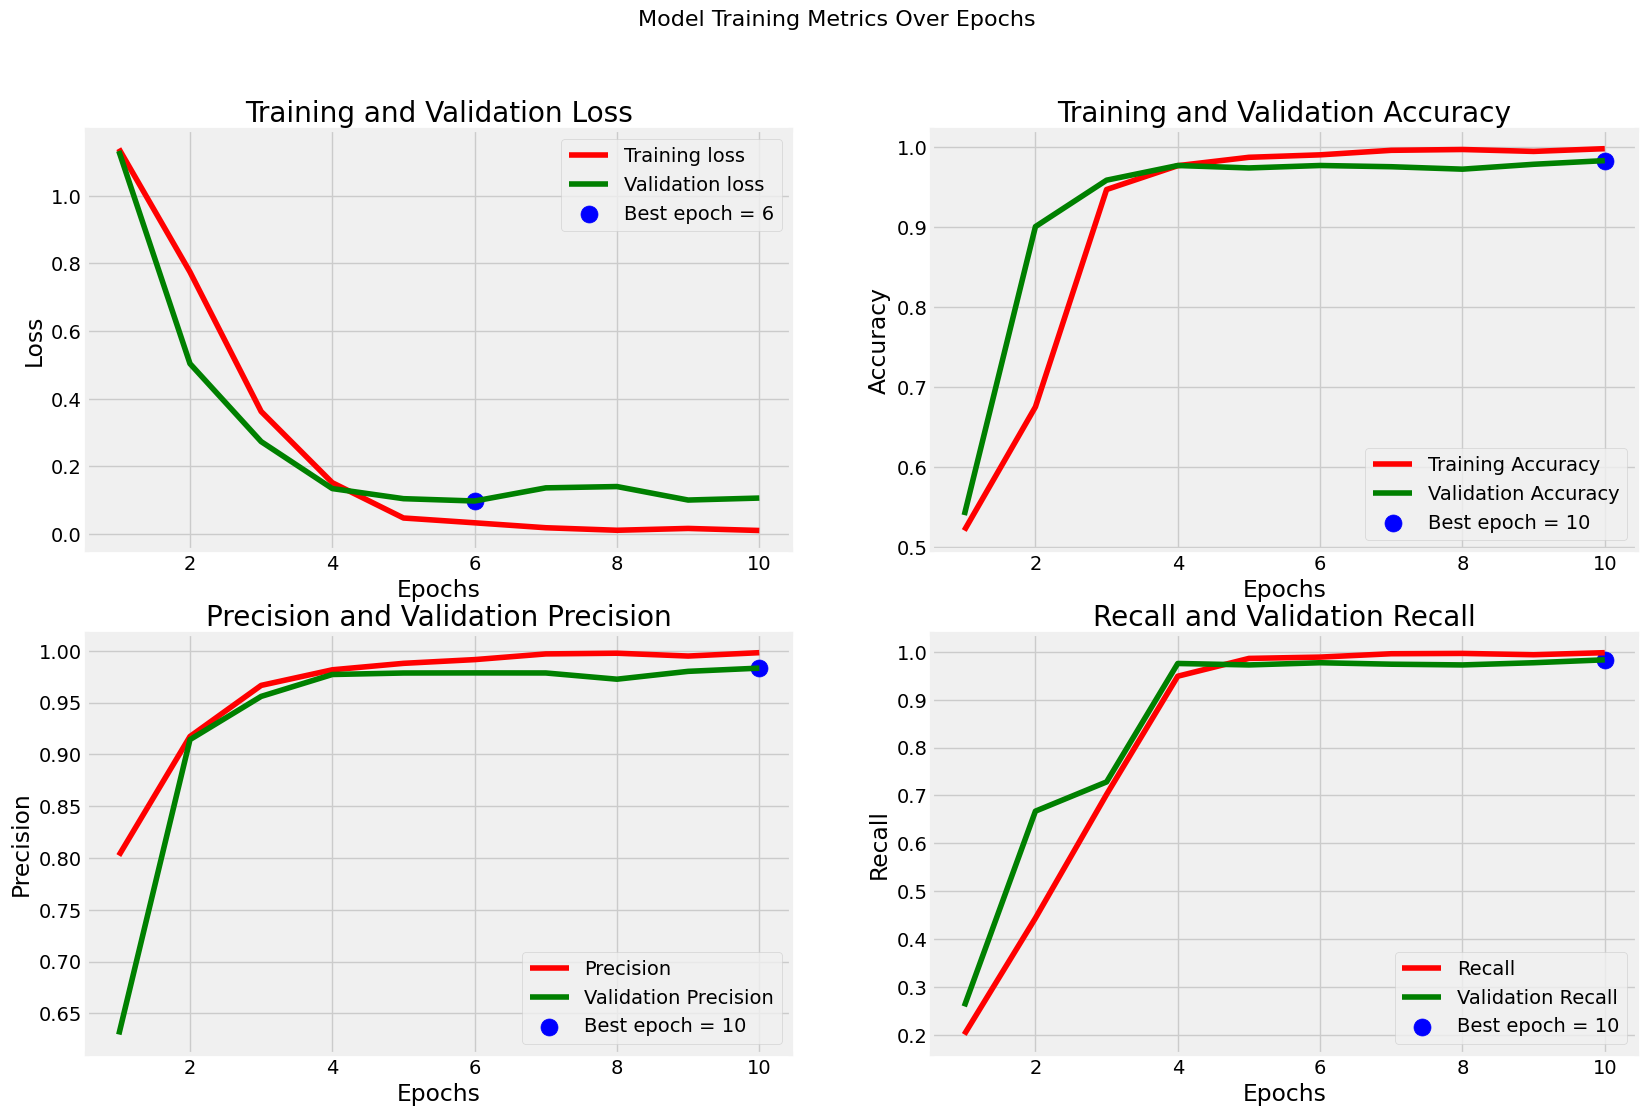

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

183/183 ━━━━━━━━━━━━━━━━━━━━ 48s 259ms/step - accuracy: 0.9997 - loss: 0.0011 - precision: 0.9997 - recall: 0.9997
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.9758 - loss: 0.1657 - precision: 0.9758 - recall: 0.9758
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.9953 - loss: 0.0183 - precision: 0.9953 - recall: 0.9953
Train Loss: 0.0014
Train Accuracy: 99.95%
--------------------
Validation Loss: 0.0998
Validation Accuracy: 98.32%
--------------------
Test Loss: 0.0391
Test Accuracy: 99.09%


In [ ]:
preds = model.predict(test_gen_copy)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step


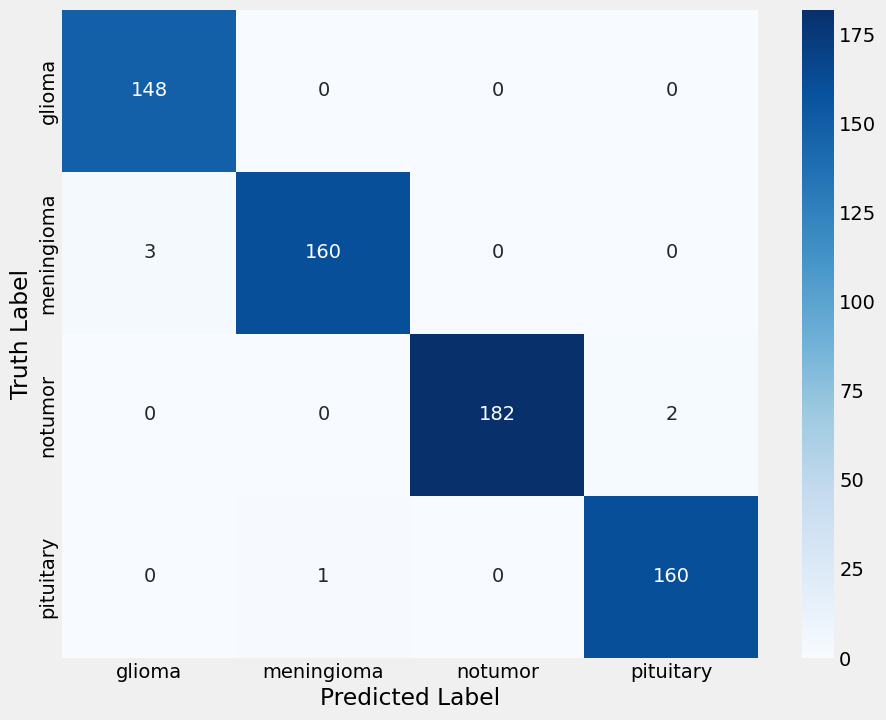

In [ ]:
### Confusion Matrix

cm = confusion_matrix(test_gen_copy.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
### Functin for getting predictions

def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()